<a href="https://colab.research.google.com/github/Chada2307/MoodTracker/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

##drive.mount('/content')  # Podłączanie Dysku Google
data_path = "/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/archive.zip"  # Ścieżka do pliku


with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
os.listdir("/content/test")

['neutral', 'angry', 'surprise', 'happy', 'disgust', 'sad', 'fear']

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience  # ile epok czekamy zanim przerwiemy
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # im mniejszy loss, tym lepiej

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:


transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(48, scale=(0.9, 1.0)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
data_dir = "/content"

batch_size=64


train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform_train)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

print(os.cpu_count())

Train dataset size: 28709 images
Test dataset size: 7178 images
2


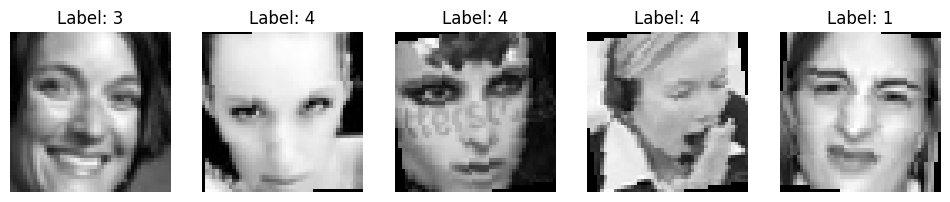

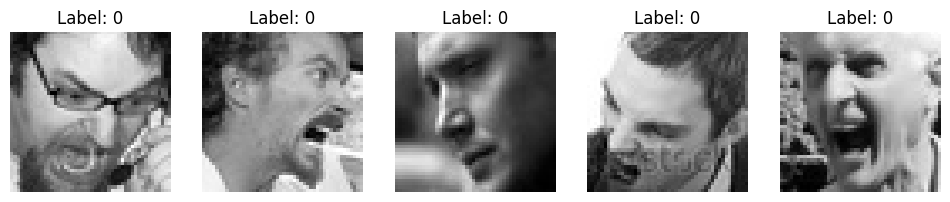

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

dataiter1 = iter(test_loader)
images, labels = next(dataiter1)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EmocjeCNN(nn.Module):
  def __init__(self):
    super(EmocjeCNN,self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)

    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(128 * 6 * 6 , 256)
    self.dropout = nn.Dropout(0.4)
    self.fc2 = nn.Linear(256, 7)

  def forward(self,x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = x.view(-1, 128 * 6 * 6)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [ ]:

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmocjeCNN().to(device)

kryteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

print("GPU dostępne:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak GPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []



GPU dostępne: True
Nazwa GPU: Tesla T4


In [ ]:
checkpoint = torch.load('/content/model_checkpoint.pth')

# Załadowanie stanu modelu i optymalizatora
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Kontynuowanie treningu
start_epoch = checkpoint['epoch'] + 1
train_loss = checkpoint['train_loss']
test_loss = checkpoint['test_loss']
early_stopping_counter = 0
print(f"Model loaded")

Model loaded


In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=True, path='best_model.pth')

In [ ]:
from tqdm import tqdm




num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc = "training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = kryteria(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / total


    model.eval()
    correct_test = 0
    total_test = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc = "validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = kryteria(outputs, labels)

            test_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_loss = test_running_loss / total_test


    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Accuracy: {train_acc:.2f}%, Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%, Loss: {test_loss:.4f}")
    print("-" * 40)


    ##early_stopping(test_loss, model)

   ## if early_stopping.early_stop:
     ##   print("Wczesne zatrzymanie treningu! ⛔")
     ##   break




    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'test_loss': test_loss,
    }, 'model_checkpoint.pth')

validation: 100%|██████████| 113/113 [00:03<00:00, 33.59it/s]


Epoch [1/50]
Train Accuracy: 62.59%, Loss: 0.9946
Test Accuracy: 61.83%, Loss: 1.0062
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.32it/s]


Epoch [2/50]
Train Accuracy: 62.77%, Loss: 0.9971
Test Accuracy: 62.16%, Loss: 1.0186
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.18it/s]


Epoch [3/50]
Train Accuracy: 62.79%, Loss: 0.9960
Test Accuracy: 61.37%, Loss: 1.0279
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 36.81it/s]


Epoch [4/50]
Train Accuracy: 63.00%, Loss: 0.9904
Test Accuracy: 60.76%, Loss: 1.0468
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 31.20it/s]


Epoch [5/50]
Train Accuracy: 62.92%, Loss: 0.9932
Test Accuracy: 61.01%, Loss: 1.0383
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 36.68it/s]


Epoch [6/50]
Train Accuracy: 63.12%, Loss: 0.9831
Test Accuracy: 61.02%, Loss: 1.0372
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.16it/s]


Epoch [7/50]
Train Accuracy: 63.59%, Loss: 0.9761
Test Accuracy: 61.66%, Loss: 1.0278
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 33.07it/s]


Epoch [8/50]
Train Accuracy: 63.21%, Loss: 0.9797
Test Accuracy: 62.83%, Loss: 0.9938
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.26it/s]


Epoch [9/50]
Train Accuracy: 63.42%, Loss: 0.9773
Test Accuracy: 62.34%, Loss: 1.0111
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.04it/s]


Epoch [10/50]
Train Accuracy: 63.62%, Loss: 0.9699
Test Accuracy: 62.32%, Loss: 0.9997
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 29.74it/s]


Epoch [11/50]
Train Accuracy: 63.91%, Loss: 0.9674
Test Accuracy: 61.21%, Loss: 1.0314
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.16it/s]


Epoch [12/50]
Train Accuracy: 63.91%, Loss: 0.9676
Test Accuracy: 62.34%, Loss: 1.0065
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 35.94it/s]


Epoch [13/50]
Train Accuracy: 63.90%, Loss: 0.9682
Test Accuracy: 62.83%, Loss: 1.0098
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 31.23it/s]


Epoch [14/50]
Train Accuracy: 64.04%, Loss: 0.9592
Test Accuracy: 62.06%, Loss: 1.0336
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.43it/s]


Epoch [15/50]
Train Accuracy: 63.99%, Loss: 0.9624
Test Accuracy: 60.94%, Loss: 1.0344
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.35it/s]


Epoch [16/50]
Train Accuracy: 63.96%, Loss: 0.9610
Test Accuracy: 61.31%, Loss: 1.0334
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 36.21it/s]


Epoch [17/50]
Train Accuracy: 64.11%, Loss: 0.9603
Test Accuracy: 62.51%, Loss: 1.0053
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 31.65it/s]


Epoch [18/50]
Train Accuracy: 64.60%, Loss: 0.9518
Test Accuracy: 62.29%, Loss: 1.0040
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 37.83it/s]


Epoch [19/50]
Train Accuracy: 64.01%, Loss: 0.9557
Test Accuracy: 61.08%, Loss: 1.0191
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.60it/s]


Epoch [20/50]
Train Accuracy: 64.37%, Loss: 0.9519
Test Accuracy: 61.81%, Loss: 1.0111
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 32.82it/s]


Epoch [21/50]
Train Accuracy: 64.23%, Loss: 0.9513
Test Accuracy: 62.11%, Loss: 1.0040
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 34.29it/s]


Epoch [22/50]
Train Accuracy: 64.71%, Loss: 0.9428
Test Accuracy: 62.68%, Loss: 1.0184
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 36.82it/s]


Epoch [23/50]
Train Accuracy: 64.67%, Loss: 0.9486
Test Accuracy: 62.25%, Loss: 1.0099
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 36.51it/s]


Epoch [24/50]
Train Accuracy: 64.73%, Loss: 0.9426
Test Accuracy: 61.23%, Loss: 1.0318
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 31.30it/s]


Epoch [25/50]
Train Accuracy: 64.69%, Loss: 0.9470
Test Accuracy: 62.04%, Loss: 1.0138
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 38.34it/s]


Epoch [26/50]
Train Accuracy: 64.83%, Loss: 0.9364
Test Accuracy: 61.81%, Loss: 1.0121
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.20it/s]


Epoch [27/50]
Train Accuracy: 64.88%, Loss: 0.9377
Test Accuracy: 61.70%, Loss: 1.0235
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 30.93it/s]


Epoch [28/50]
Train Accuracy: 65.10%, Loss: 0.9356
Test Accuracy: 61.31%, Loss: 1.0418
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.10it/s]


Epoch [29/50]
Train Accuracy: 65.14%, Loss: 0.9340
Test Accuracy: 63.36%, Loss: 0.9928
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 36.79it/s]


Epoch [30/50]
Train Accuracy: 64.82%, Loss: 0.9348
Test Accuracy: 62.57%, Loss: 1.0075
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 35.39it/s]


Epoch [31/50]
Train Accuracy: 65.22%, Loss: 0.9324
Test Accuracy: 63.40%, Loss: 0.9889
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 36.48it/s]


Epoch [32/50]
Train Accuracy: 65.47%, Loss: 0.9278
Test Accuracy: 62.12%, Loss: 1.0111
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.32it/s]


Epoch [33/50]
Train Accuracy: 65.08%, Loss: 0.9310
Test Accuracy: 63.32%, Loss: 0.9920
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.50it/s]


Epoch [34/50]
Train Accuracy: 65.29%, Loss: 0.9273
Test Accuracy: 62.72%, Loss: 1.0112
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 30.25it/s]


Epoch [35/50]
Train Accuracy: 65.05%, Loss: 0.9269
Test Accuracy: 61.79%, Loss: 1.0331
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 37.70it/s]


Epoch [36/50]
Train Accuracy: 65.51%, Loss: 0.9212
Test Accuracy: 62.89%, Loss: 1.0147
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 37.88it/s]


Epoch [37/50]
Train Accuracy: 65.58%, Loss: 0.9273
Test Accuracy: 62.19%, Loss: 1.0256
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.36it/s]


Epoch [38/50]
Train Accuracy: 65.24%, Loss: 0.9237
Test Accuracy: 62.52%, Loss: 1.0162
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 30.31it/s]


Epoch [39/50]
Train Accuracy: 65.72%, Loss: 0.9135
Test Accuracy: 63.07%, Loss: 1.0251
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 38.08it/s]


Epoch [40/50]
Train Accuracy: 65.84%, Loss: 0.9185
Test Accuracy: 62.90%, Loss: 1.0114
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 38.47it/s]


Epoch [41/50]
Train Accuracy: 65.13%, Loss: 0.9259
Test Accuracy: 63.30%, Loss: 0.9859
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 35.58it/s]


Epoch [42/50]
Train Accuracy: 65.91%, Loss: 0.9100
Test Accuracy: 62.55%, Loss: 1.0102
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 33.66it/s]


Epoch [43/50]
Train Accuracy: 65.73%, Loss: 0.9159
Test Accuracy: 63.42%, Loss: 0.9930
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 37.87it/s]


Epoch [44/50]
Train Accuracy: 66.00%, Loss: 0.9124
Test Accuracy: 63.14%, Loss: 0.9840
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 37.72it/s]


Epoch [45/50]
Train Accuracy: 66.14%, Loss: 0.9101
Test Accuracy: 62.25%, Loss: 1.0385
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 31.94it/s]


Epoch [46/50]
Train Accuracy: 65.91%, Loss: 0.9107
Test Accuracy: 63.25%, Loss: 1.0038
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.05it/s]


Epoch [47/50]
Train Accuracy: 65.90%, Loss: 0.9099
Test Accuracy: 62.87%, Loss: 1.0016
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 37.36it/s]


Epoch [48/50]
Train Accuracy: 66.01%, Loss: 0.9046
Test Accuracy: 62.58%, Loss: 1.0145
----------------------------------------


validation: 100%|██████████| 113/113 [00:02<00:00, 38.37it/s]


Epoch [49/50]
Train Accuracy: 66.18%, Loss: 0.9096
Test Accuracy: 61.41%, Loss: 1.0363
----------------------------------------


validation: 100%|██████████| 113/113 [00:03<00:00, 32.90it/s]

Epoch [50/50]
Train Accuracy: 66.02%, Loss: 0.9059
Test Accuracy: 62.57%, Loss: 1.0198
----------------------------------------


NameError: name 'val_accuracy' is not defined

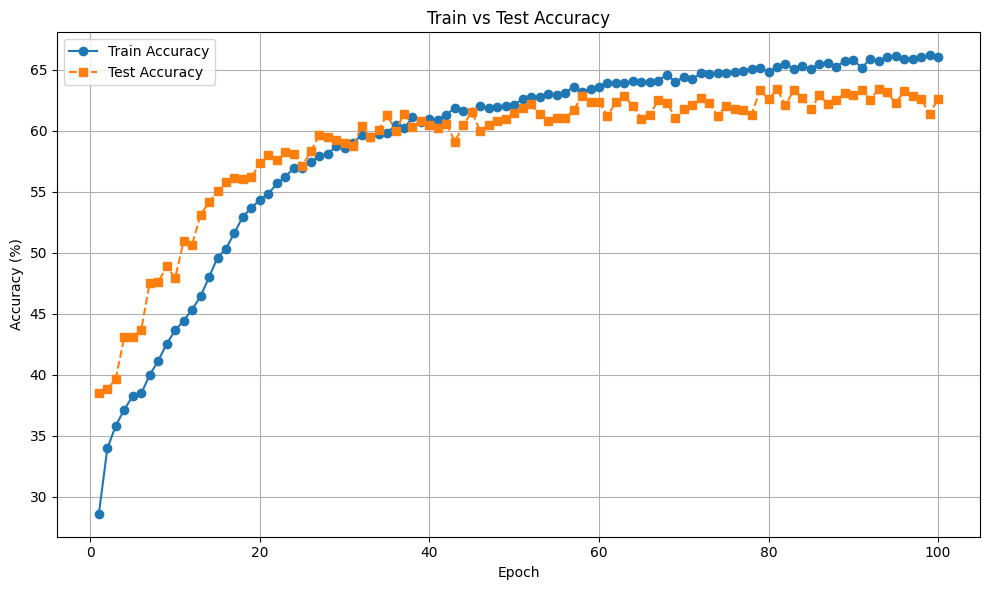

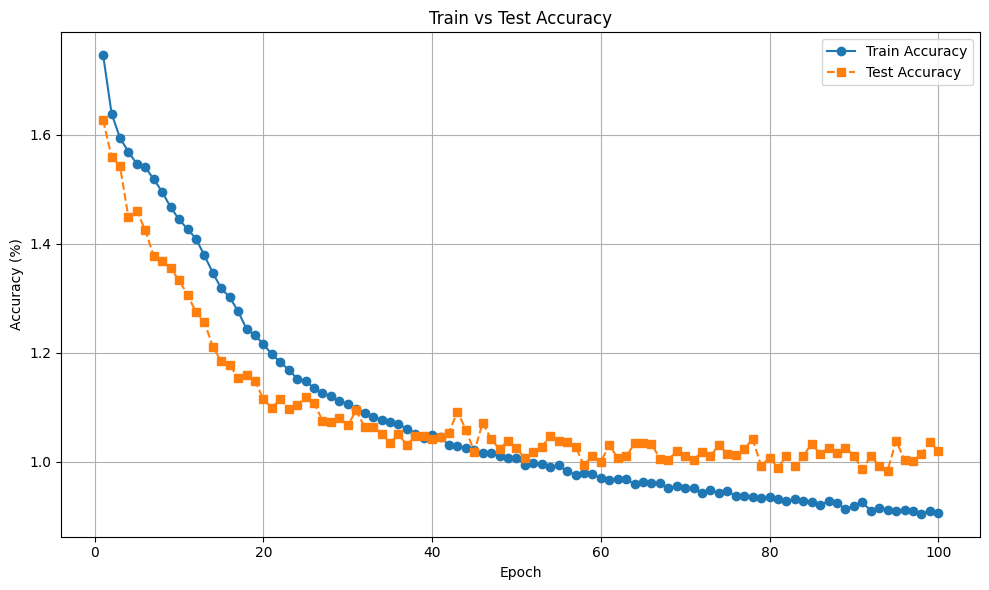

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 's--', label='Test Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_accuracy(train_accuracies, test_accuracies)
plot_accuracy(train_losses, test_losses)